Here I try a variety of bayesian models on a few of the features to get a sense of what might be more important

In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm
import pickle
import matplotlib.pyplot as pl
from sklearn.preprocessing import StandardScaler
from matplotlib import rcParams
import theano.tensor as tt
import seaborn as sb
import pathlib

In [3]:
% matplotlib inline
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['font.size'] = 14
rcParams['axes.titlesize'] = 18
rcParams['figure.titlesize'] = 20

In [4]:
from IPython.core.display import HTML, display
display(HTML("<style>.container {width: 90% !important}</style>"))

In [5]:
# Load the dataset:
home = pathlib.Path.home()
dataDir = home / 'DATA/Beaching_Project/PklJar'
with open(dataDir / 'CapeCodDataDict.pkl', 'rb') as f:
    dataDict = pickle.load(f)

I'll start with the wind data as feature and the total number of strandings as target

In [6]:
dataDict['Features'].keys()

dict_keys(['CENSUS', 'MAG', 'SUN', 'TIDE', 'WATER', 'WIND'])

In [7]:
strandings = dataDict['Targets']['TOTAL']

In [8]:
strandings.head()

,num_stranded,event
1999-03-07,6.0,1
1999-03-08,0.0,0
1999-03-09,0.0,0
1999-03-10,0.0,0
1999-03-11,0.0,0


In [9]:
strandings = strandings.loc['1999-03-07':]

In [39]:
df = pd.DataFrame(dataDict['Features']['WIND'])

In [40]:
df['Month'] = df.index.month
df['Year' ] = df.index.year

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5844 entries, 1999-01-01 to 2014-12-31
Freq: D
Data columns (total 14 columns):
EasterlyWS         5397 non-null float64
SoutherlyWS        5397 non-null float64
EasterlyWS_1d      5396 non-null float64
SoutherlyWS_1d     5396 non-null float64
EasterlyWS_2d      5395 non-null float64
SoutherlyWS_2d     5395 non-null float64
EasterlyWS_3d      5394 non-null float64
SoutherlyWS_3d     5394 non-null float64
EasterlyWS_7d      5390 non-null float64
SoutherlyWS_7d     5390 non-null float64
EasterlyWS_30d     5367 non-null float64
SoutherlyWS_30d    5367 non-null float64
Month              5844 non-null int64
Year               5844 non-null int64
dtypes: float64(12), int64(2)
memory usage: 684.8 KB


In [13]:
dfWS = pd.DataFrame(np.sqrt(df.EasterlyWS**2 + df.SoutherlyWS**2), columns=['WS'])
dfWS['Month'] = df.Month
dfWS['Year'] = df.Year

In [14]:
dfWS_Monthly = dfWS.resample('M').mean()

In [15]:
print(dfWS_Monthly.head())
print(dfWS_Monthly.tail())

                  WS  Month  Year
1999-01-31  6.337813      1  1999
1999-02-28  5.587788      2  1999
1999-03-31  6.479795      3  1999
1999-04-30  3.414578      4  1999
1999-05-31  3.186250      5  1999
                  WS  Month  Year
2014-08-31  3.087178      8  2014
2014-09-30  3.646902      9  2014
2014-10-31  5.958362     10  2014
2014-11-30  6.655850     11  2014
2014-12-31  6.443955     12  2014


In [16]:
dfWS_Monthly['Month'] = dfWS_Monthly.index.month
dfWS_Monthly['Year'] = dfWS_Monthly.index.year

In [17]:
dfWS_Monthly.head()

,WS,Month,Year
1999-01-31,6.337813,1,1999
1999-02-28,5.587788,2,1999
1999-03-31,6.479795,3,1999
1999-04-30,3.414578,4,1999
1999-05-31,3.186250,5,1999


In [18]:
bad_months = dfWS_Monthly[(dfWS_Monthly.WS.isnull())].index.month.unique().tolist()
dfWS_M_clean = dfWS_Monthly.copy()

for month in bad_months:
    dfWS_M_clean.loc[(dfWS_M_clean.WS.isnull()) &
                     (dfWS_M_clean.index.month==month), 'WS'] = dfWS_M_clean.loc [dfWS_M_clean.index.month==month,
                                                                        'WS'].mean()

In [19]:
dfWS_pivot = dfWS_M_clean.pivot("Month", "Year", "WS")

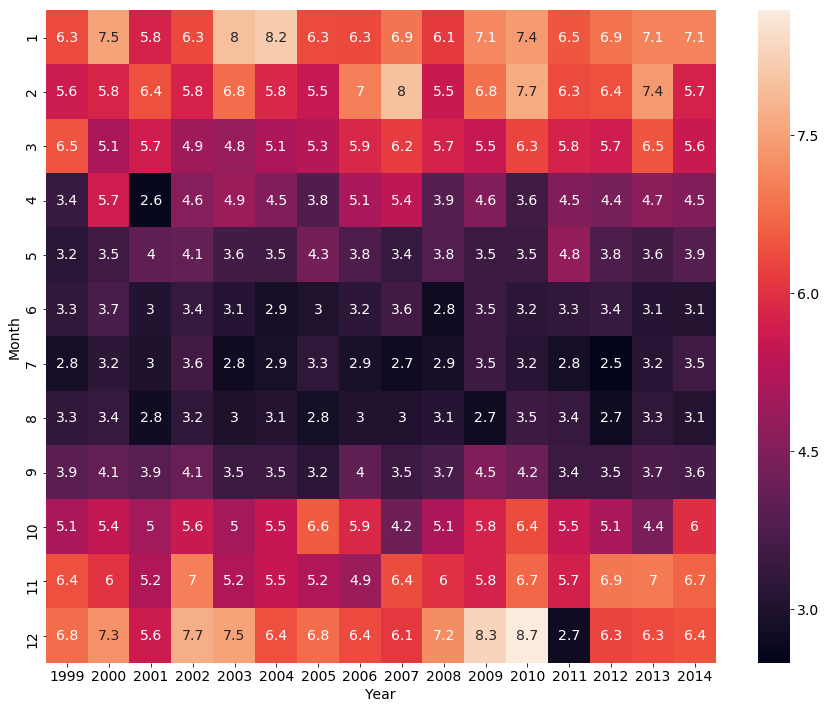

In [21]:
_, ax = pl.subplots(figsize=(15, 12))
sb.heatmap(dfWS_pivot, annot=True, ax=ax)

In [22]:
strandings = dataDict['Targets']['TOTAL']

In [23]:
strandings.head()

,num_stranded,event
1999-03-07,6.0,1
1999-03-08,0.0,0
1999-03-09,0.0,0
1999-03-10,0.0,0
1999-03-11,0.0,0


In [24]:
strandings = pd.DataFrame(strandings, columns=['num_stranded'])

In [27]:
strand_M = strandings.resample('M').sum()

In [28]:
strand_M.rename(columns={0: 'num_stranded'}, inplace=True)

In [29]:
strand_M.head()

,num_stranded
1999-03-31,56.0
1999-04-30,0.0
1999-05-31,0.0
1999-06-30,2.0
1999-07-31,0.0


The stranding dataset starts on March 7, 1997. So I'll trim the dataset used here to start then:

In [30]:
strand_M = strand_M.loc['1999-03-31':]
dfWS_M = dfWS_M_clean.loc['1999-03-31':]

In [31]:
df = pd.concat([dfWS_M, strand_M], axis=1, copy=False)

In [32]:
df.head()

,WS,Month,Year,num_stranded
1999-03-31,6.479795,3,1999,56.0
1999-04-30,3.414578,4,1999,0.0
1999-05-31,3.186250,5,1999,0.0
1999-06-30,3.308266,6,1999,2.0
1999-07-31,2.829669,7,1999,0.0


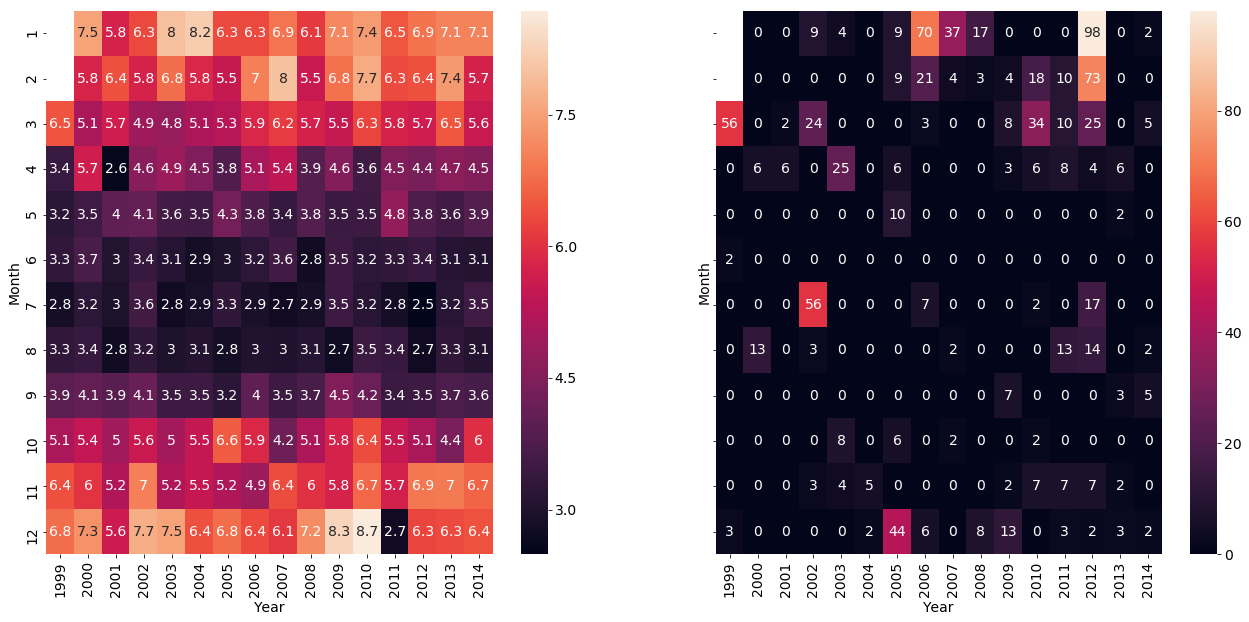

In [33]:
_, ax = pl.subplots(ncols=2, sharey=True, figsize=(22, 10))
df_pivot_ws = df.pivot('Month', 'Year', 'WS')
df_pivot_strand = df.pivot('Month', 'Year', 'num_stranded')
sb.heatmap(df_pivot_ws, annot=True, ax=ax[0])
sb.heatmap(df_pivot_strand, annot=True, ax=ax[1])

In [34]:
strandings.head()

,num_stranded
1999-03-07,6.0
1999-03-08,0.0
1999-03-09,0.0
1999-03-10,0.0
1999-03-11,0.0


In [36]:
df.head()

,WS,Month,Year
1999-01-01,8.596158,1,1999
1999-01-02,10.573917,1,1999
1999-01-03,6.326630,1,1999
1999-01-04,7.188480,1,1999
1999-01-05,8.480868,1,1999


My first model will be that of a logistic regression, with the goal of predicting when any strandings (TOTAL>0) occurs. Note here that a stranding event was originally labeled as such when more than one animal had stranded.

There are some nans among the wind, so I'll make a new dataframe with both wind and strandings and drop rows where nans appear

In [44]:
dfs = pd.concat([df[['EasterlyWS', 'SoutherlyWS']], strandings], axis=1)
dfs.rename(columns={None: 'TotalStranded'}, inplace=True)

In [48]:
dfs['month'] = dfs.index.month

In [49]:
dfs.head()

,EasterlyWS,SoutherlyWS,num_stranded,month
1999-01-01,-8.369086,-1.962736,NaN,1
1999-01-02,-10.358338,2.124278,NaN,1
1999-01-03,5.530758,-3.071964,NaN,1
1999-01-04,-6.726604,-2.535160,NaN,1
1999-01-05,-8.472319,-0.380683,NaN,1


In [43]:
boolStrand = strandings>0
boolStrand.rename(columns={None: 'stranded'}, inplace=True)

In [44]:
boolStrand.head()

,stranded
1999-03-07,True
1999-03-08,False
1999-03-09,False
1999-03-10,False
1999-03-11,False


In [45]:
dfs = pd.concat([wind, boolStrand], axis=1)

In [46]:
dfs.head()

,EasterlyWS,SoutherlyWS,EasterlyWS_1d,SoutherlyWS_1d,EasterlyWS_2d,SoutherlyWS_2d,EasterlyWS_3d,SoutherlyWS_3d,EasterlyWS_7d,SoutherlyWS_7d,EasterlyWS_30d,SoutherlyWS_30d,stranded
1999-03-07,-1.597614,11.183859,3.570062,2.563992,-9.224087,-0.046570,3.179750,-9.103259,2.036880,-1.265833,-5.350695,5.959278,True
1999-03-08,-10.374381,7.568804,-1.597614,11.183859,3.570062,2.563992,-9.224087,-0.046570,2.733924,-6.260351,-4.862086,1.981418,False
1999-03-09,-8.124423,5.416860,-10.374381,7.568804,-1.597614,11.183859,3.570062,2.563992,-4.567401,-4.513101,-7.616287,2.540035,False
1999-03-10,-4.053519,2.885376,-8.124423,5.416860,-10.374381,7.568804,-1.597614,11.183859,-1.074112,-1.885289,-0.946676,4.569450,False
1999-03-11,-7.269797,4.485525,-4.053519,2.885376,-8.124423,5.416860,-10.374381,7.568804,3.179750,-9.103259,-2.245282,-2.983975,False


In [55]:
df_clean = df.dropna()
x_wind = df_clean.as_matrix(columns=['EasterlyWS', 'SoutherlyWS'])
y_bool = df_clean.TotalStranded.values
ss = StandardScaler()
x_wind_s = ss.fit_transform(x_wind)

In [28]:
num_samples = y_bool.size

Can I make cyclical time?

In [50]:
dfs.head()

,EasterlyWS,SoutherlyWS,num_stranded,month
1999-01-01,-8.369086,-1.962736,NaN,1
1999-01-02,-10.358338,2.124278,NaN,1
1999-01-03,5.530758,-3.071964,NaN,1
1999-01-04,-6.726604,-2.535160,NaN,1
1999-01-05,-8.472319,-0.380683,NaN,1


In [43]:
df.head()

,EasterlyWS,SoutherlyWS,EasterlyWS_1d,SoutherlyWS_1d,EasterlyWS_2d,SoutherlyWS_2d,EasterlyWS_3d,SoutherlyWS_3d,EasterlyWS_7d,SoutherlyWS_7d,EasterlyWS_30d,SoutherlyWS_30d,Month,Year
1999-01-01,-8.369086,-1.962736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1999
1999-01-02,-10.358338,2.124278,-8.369086,-1.962736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1999
1999-01-03,5.530758,-3.071964,-10.358338,2.124278,-8.369086,-1.962736,NaN,NaN,NaN,NaN,NaN,NaN,1,1999
1999-01-04,-6.726604,-2.535160,5.530758,-3.071964,-10.358338,2.124278,-8.369086,-1.962736,NaN,NaN,NaN,NaN,1,1999
1999-01-05,-8.472319,-0.380683,-6.726604,-2.535160,5.530758,-3.071964,-10.358338,2.124278,NaN,NaN,NaN,NaN,1,1999


In [51]:
dfs['sin_month'] = np.sin(2*np.pi * dfs.month / 12)
dfs['cos_month'] = np.cos(2*np.pi * dfs.month / 12)

In [55]:
dfs.sin_month.unique()

array([  5.00000000e-01,   8.66025404e-01,   1.00000000e+00,
         8.66025404e-01,   1.22464680e-16,  -5.00000000e-01,
        -8.66025404e-01,  -1.00000000e+00,  -8.66025404e-01,
        -5.00000000e-01,  -2.44929360e-16])

In [52]:
dfs.head()

,EasterlyWS,SoutherlyWS,num_stranded,month,sin_month,cos_month
1999-01-01,-8.369086,-1.962736,NaN,1,0.5,0.866025
1999-01-02,-10.358338,2.124278,NaN,1,0.5,0.866025
1999-01-03,5.530758,-3.071964,NaN,1,0.5,0.866025
1999-01-04,-6.726604,-2.535160,NaN,1,0.5,0.866025
1999-01-05,-8.472319,-0.380683,NaN,1,0.5,0.866025
